<a href="https://colab.research.google.com/github/Jana-Alrzoog/2025_GP_28/blob/main/masar-sim/notebooks/masar_base_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Masar Baseline Passenger Demand Generation Notebook

This notebook **programmatically constructs a normalized baseline demand curve** to represent typical daily passenger flow patterns.


It models **recurring weekday behavior** with predictable **morning and evening peaks**, producing a standard reference profile that can be used for downstream simulation, forecasting, and evaluation tasks.



---
# 🎯 Purpose

The goal of this notebook is to **generate a reusable 24-hour baseline demand** profile that can serve as an input for:

* Daily, weekly, or monthly ridership simulations
* Scenario testing and event-driven modifiers
* Real-time prediction pipelines
* QA dashboards and operational analysis

---

# ⚙️ Workflow Overview

1️⃣ Load configuration Import simulation settings, parameters, and time-based controls.

2️⃣ Generate core demand curve
Construct the daily pattern using Gaussian-based morning and evening peaks.

3️⃣ Apply normalization
Scale the baseline profile to ensure comparability across scenarios.

4️⃣ Visualize and validate
Plot the generated curve to confirm expected pattern behavior.

5️⃣ Export as base_day.csv for later notebooks


In [ ]:
# Masar Base Demand Generation Notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml, json

In [ ]:
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd 2025_GP_28


Cloning into '2025_GP_28'...
remote: Enumerating objects: 827, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 827 (delta 25), reused 9 (delta 4), pack-reused 760 (from 4)
Receiving objects: 100% (827/827), 23.76 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (305/305), done.
/content/2025_GP_28


In [ ]:
# Load Configuration Files
seed_path = "/content/2025_GP_28/masar-sim/data/seeds"
config_path = "/content/2025_GP_28/masar-sim/sims/00_config.yaml"

with open(config_path) as f:
    config = yaml.safe_load(f)

with open(f"{seed_path}/stations.json") as f:
    stations = json.load(f)

print(f"Loaded {len(stations)} stations")

Loaded 6 stations


In [ ]:
import yaml

CONF = "/content/2025_GP_28/masar-sim/sims/00_config.yaml"


with open(CONF, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

print("Peaks:", config["peaks"])
print("Baseline:", config.get("baseline"))
print("Global Scale:", config.get("global_scale"))

Peaks: [{'hour': 8, 'sigma_hours': 0.75, 'weight': 1.6}, {'hour': 18, 'sigma_hours': 0.85, 'weight': 1.6}, {'hour': 12, 'sigma_hours': 0.7, 'weight': 1.2}, {'hour': 16, 'sigma_hours': 0.7, 'weight': 1.2}]
Baseline: 0.05
Global Scale: 2.2


This code defines the mathematical model for demand peaks. A gaussian ( or bell curve ) function is employed as it provides a smooth and realistic model for the gradual rise and fall of passenger volume during peak commute hours. A second function, base_demand_curve, combines multiple Gaussian curves to represent both the morning and evening peaks.

In [ ]:
# Gaussian-based Base Demand Function

def base_demand_curve(minute_of_day, config):
    """
    Compute base demand for a given minute of the day using:
      - baseline
      - multiple Gaussian peaks (each with hour, sigma, weight)
      - global_scale (to raise overall demand levels)
    """

    peaks = config.get("peaks", [])

    baseline = config.get("baseline", 0.05)


    global_scale = config.get("global_scale", 3.0)

    demand = baseline

    for p in peaks:
        mu = p["hour"] * 60
        sigma_h = p["sigma_hours"]
        weight = p.get("weight", 1.0)
        demand += weight * gaussian(minute_of_day, mu, sigma_h)
    demand *= global_scale

    return demand

In [ ]:
def gaussian(x, mu, sigma_h):
    sigma = sigma_h * 60
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)


In [ ]:
def base_demand_curve(minute_of_day, config):
    peaks = config.get("peaks", [])

    baseline = config.get("baseline", 0.05)
    global_scale = config.get("global_scale", 3.0)

    demand = baseline

    for p in peaks:
        mu = p["hour"] * 60
        sigma_h = p["sigma_hours"]
        weight = p.get("weight", 1.0)

        demand += weight * gaussian(minute_of_day, mu, sigma_h)

    return demand * global_scale


This function, generate_base_day, constructs a full demand profile for
a single station across an entire day. It creates a minute-by-minute
timeline, applies the Gaussian-based demand model from Section 2 to each minute, and assembles the results into a DataFrame containing timestamps station ID, and the corresponding base demand values.


In [ ]:
# Generate Daily Curve (One Station Example)

def generate_base_day(station_id, config):
    start = datetime(2025, 7, 1, 6, 0)
    end   = datetime(2025, 7, 2, 0, 0)

    times = pd.date_range(start, end, freq="1min")
    minutes = [t.hour * 60 + t.minute for t in times]

    base_values = [base_demand_curve(m, config) for m in minutes]

    df = pd.DataFrame({
        "timestamp": times,
        "station_id": station_id,
        "base_demand_norm": base_values
    })

    return df


Here shows a visual validation step. It runs the function from Section 3 for a single sample station and plots the resulting curve using matplotlib. This visual inspection allows for confirmation that the curve exhibits the expected bimodal (two-peak) distribution corresponding to morning and evening commutes

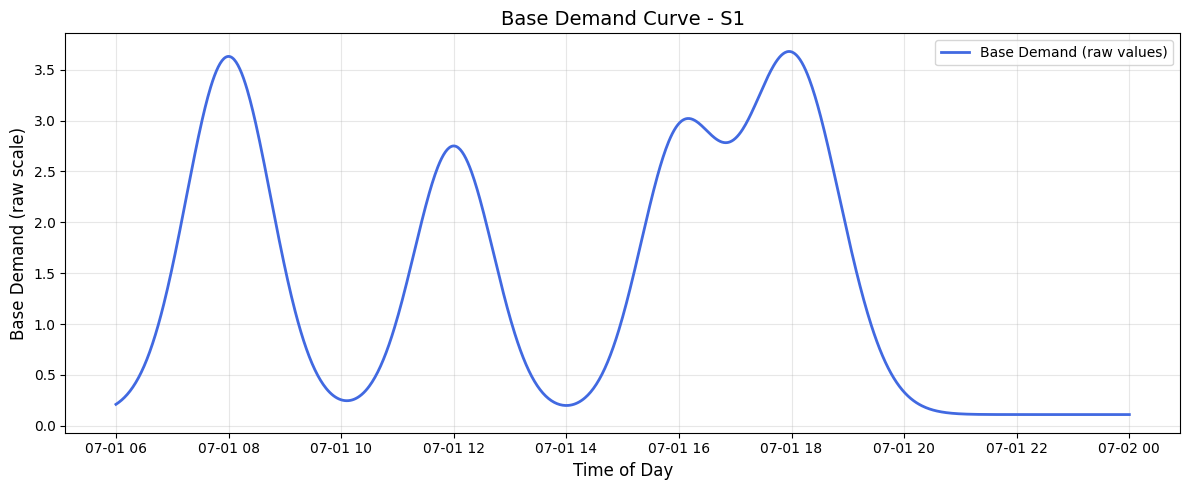

In [ ]:
# Plot Example

example_station = "S1"
df_example = generate_base_day(example_station, config)

plt.figure(figsize=(12,5))
plt.plot(
    df_example["timestamp"],
    df_example["base_demand_norm"],
    label="Base Demand (raw values)",
    color="royalblue",
    linewidth=2
)

plt.title(f"Base Demand Curve - {example_station}", fontsize=14)
plt.xlabel("Time of Day", fontsize=12)
plt.ylabel("Base Demand (raw scale)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  Generate for All Stations

stations = ["S1", "S2", "S3", "S4", "S5"]

for sid in stations:
    df = generate_base_day(sid, config)
    df.to_csv(f"base_day_{sid}.csv", index=False)

print("✔ Saved all base-day CSV files!")


✔ Saved all base-day CSV files!


In [ ]:
df_test = generate_base_day("S1", config)
print(df_test.columns)
df_test.head()

Index(['timestamp', 'station_id', 'base_demand_norm'], dtype='object')


,timestamp,station_id,base_demand_norm
0,2025-07-01 06:00:00,S1,0.210551
1,2025-07-01 06:01:00,S1,0.216663
2,2025-07-01 06:02:00,S1,0.223091
3,2025-07-01 06:03:00,S1,0.229847
4,2025-07-01 06:04:00,S1,0.236944


In [ ]:
# Save the Base Demand to CSV


import pandas as pd

stations = ["S1", "S2", "S3", "S4", "S5","S6"]

all_rows = []

for sid in stations:
    df = generate_base_day(sid, config)


    df["base_demand"] = df["base_demand_norm"]


    df = df[["timestamp", "station_id", "base_demand", "base_demand_norm"]]

    all_rows.append(df)


df_all = pd.concat(all_rows, ignore_index=True)


df_all.to_csv("base_day_all_stations.csv", index=False)

print("✔️ Saved base_day_all_stations.csv")



✔️ Saved base_day_all_stations.csv


In [ ]:
from google.colab import files
files.download("base_day_all_stations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>